# Image Similarity Estimation using a Siamese Network
The goal: given a database of anime images and an image of the user's face, return the top 5 anime characters that most closely resemble the user.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting and graphics

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import random

import keras
from keras import applications
from keras.applications import resnet
from keras import ops, layers
from keras import optimizers, metrics

import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

TARGET_SHAPE=(256, 256)
os.environ["KERAS_BACKEND"] = "tensorflow"
autotune = tf.data.AUTOTUNE

As a placeholder dataset, we use the **Totally Looks Like** dataset to test the capabilities of the Siamese Network. Once the **CycleGAN** is able to amass a repository of real/anime image-pairs, we can train **ISSN** on our custom dataset.

In [6]:
def preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, TARGET_SHAPE)
    return image

In [34]:
def load_dataset(path):
    image_paths = tf.data.Dataset.list_files(
        os.path.join(path, '*'),
        shuffle=False
    )
    dataset = image_paths.map(
        preprocess_image,
        num_parallel_calls=autotune
    )
    return dataset

In [35]:
AnchorImages = load_dataset('/kaggle/input/totally-looks-like-dataset/left/left')
PositiveImages = load_dataset('/kaggle/input/totally-looks-like-dataset/right/right')

In [36]:
NegativeImages = tf.data.experimental.sample_from_datasets([AnchorImages, PositiveImages])

In [37]:
ISSNDataset = tf.data.Dataset.zip((
    AnchorImages,
    PositiveImages,
    NegativeImages
)).shuffle(buffer_size=1024)

In [38]:
SPLIT = round(len(AnchorImages) * 0.8)
ISSNTrain = ISSNDataset.take(SPLIT).batch(32, drop_remainder=False).prefetch(autotune)
ISSNVal = ISSNDataset.skip(SPLIT).batch(32, drop_remainder=False).prefetch(autotune)

We can look at a few examples of the triplets. The Anchor and Positive images should match, while the Negative image is *always*different.

In [39]:
def visualize(anchor, positive, negative):
    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))
    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

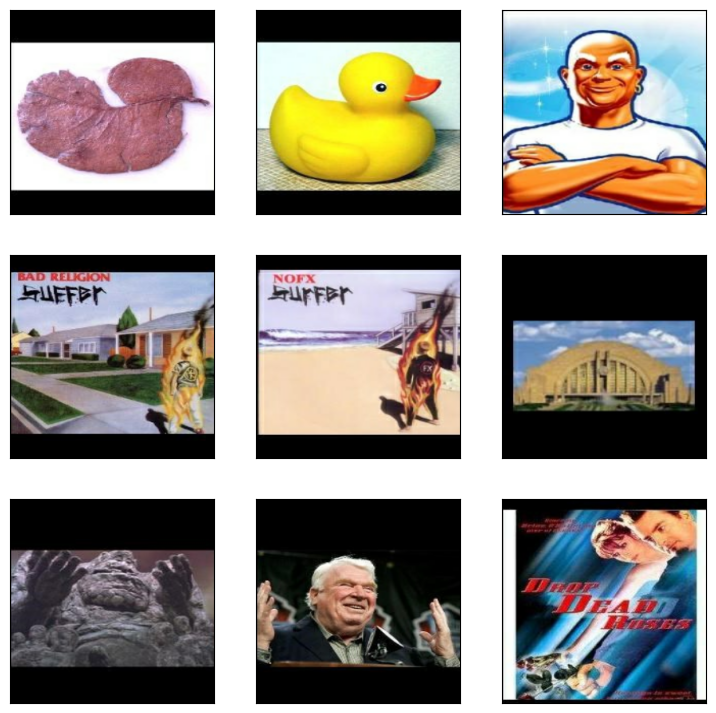

In [40]:
batch = next(
    iter(
        ISSNTrain.take(1).as_numpy_iterator()
    )
)  # Get one batch
visualize(*batch)  # Unpack the batch

## Create a Siamese Network from the ResNET 50 Model

In [41]:
ResNET50 = resnet.ResNet50(
    weights = "imagenet",
    input_shape = TARGET_SHAPE + (3,),
    include_top = False
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


The Siamese Network will generate embeddings for each of the images of the triplet using a **ResNet50** model pretrained on ImageNet. It will connect to a few Dense layers so we can learn to separate these embeddings.

We will freeze the weights of all the layers of the model up until the layer `conv5_block1_out`to avoid changing the weights that the model has already learned (that would be bad!). Thus, we are going to leave the bottom few layers trainable so that we can fine-tune their weights during training.

In [46]:
flatten = layers.Flatten()(ResNET50.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

Embedder = keras.Model(ResNET50.input, output, name="ResNET50_Embedding")

We also need a **Custom Layer** to compute the distance between the anchor and the positive embedding, as well as the distance between the anchor and the negative embedding.

In [48]:
class APNDistance(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = ops.sum(tf.square(anchor - positive), -1)
        an_distance = ops.sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

In [53]:
anchor_input = layers.Input(name="anchor", shape=TARGET_SHAPE + (3,))
positive_input = layers.Input(name="positive", shape=TARGET_SHAPE + (3,))
negative_input = layers.Input(name="negative", shape=TARGET_SHAPE + (3,))

In [57]:
Distance = APNDistance()(
    Embedder(resnet.preprocess_input(anchor_input)),
    Embedder(resnet.preprocess_input(positive_input)),
    Embedder(resnet.preprocess_input(negative_input))
)

In [58]:
SiameseNetworkModel = keras.Model(
    inputs = [anchor_input, positive_input, negative_input],
    outputs = Distance,
    name = "SiameseNetworkModel"
)

In [59]:
SiameseNetworkModel.summary()

Model: "SiameseNetworkModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ anchor (InputLayer)       │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positive (InputLayer)     │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ negative (InputLayer)     │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_36 (GetItem)     │ (None, 256, 256)       │              0 │ anchor[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_37 (GetItem)     │ (None, 256, 256)       │              0 │ anchor[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_38 (GetItem)     │ (None, 256, 256)       │              0 │ anchor[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_39 (GetItem)     │ (None, 256, 256)       │              0 │ positive[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_40 (GetItem)     │ (None, 256, 256)       │              0 │ positive[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_41 (GetItem)     │ (None, 256, 256)       │              0 │ positive[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_42 (GetItem)     │ (None, 256, 256)       │              0 │ negative[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_43 (GetItem)     │ (None, 256, 256)       │              0 │ negative[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_44 (GetItem)     │ (None, 256, 256)       │              0 │ negative[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_12 (Stack)          │ (None, 256, 256, 3)    │              0 │ get_item_36[0][0],     │
│                           │                        │                │ get_item_37[0][0],     │
│                           │                        │                │ get_item_38[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_13 (Stack)          │ (None, 256, 256, 3)    │              0 │ get_item_39[0][0],     │
│                           │                        │                │ get_item_40[0][0],     │
│                           │                        │                │ get_item_41[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_14 (Stack)          │ (None, 256, 256, 3)    │              0 │ get_item_42[0][0],     │
│                           │                        │                │ get_item_43[0][0],     │
│                           │                        │                │ get_item_44[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_12 (Add)              │ (None, 256, 256, 3)    │              0 │ stack_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_13 (Add)         

 Total params: 90,897,280 (346.75 MB)

 Trainable params: 90,842,624 (346.54 MB)

 Non-trainable params: 54,656 (213.50 KB)

## Train the Model 
Implement a model with custom training loop so we can compute the triplet loss using the three embeddings produced by the Siamese network.

In [61]:
class SiameseImageSimilarityModel(keras.Model):
    def __init__(self, actual_network, margin=.5):
        super().__init__()
        self.siamese_network = actual_network
        self.margin = margin

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0) #can't have negative loss
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]